In [1]:
using XSteam

using DataFrames

mutable struct steamObj
    P::Real # Pressure (Bar)
    T::Real # Temperature (C)
    h::Real # enthalpy (kJ/kg)
    s::Real # entropy (kJ/kg)
    x::Real # vapor fraction
end


"""
    initSuperHeatedWater(P::Real)

    Initializes superheatedwater properties
"""
function initSuperHeatedWater(P::Real,T::Real)
  #  assumes vapor fraction = 1, i.e. fluid is 100% superheated 
    h = h_pT(P,T);
    s = s_pT(P,T)
    return steamObj(P,T,h,s,1);
end

"""
    initLiquidWater(P::Real)

    Initializes saturated water properties
"""
function initLiquidWater(P::Real)
    h = h_px(P,0);
    s = s_ph(P,h);
    x = x_ph(P,h);
    T = Tsat_p(P);
    return steamObj(P,T,h,s,x);
end

"""
    steam_initPrePump(P::Vector{Real}) or (P::Real)

    Initializes saturated water properties for a given pressure at the inlet to a pump, if there are multiple pumps supply the pressrues as a
"""
function h2o_initPrePump(P::Vector{<:Real})
    #assumes vapor fraction = 0, i.e. fluid is 100% liquid
    npts = length(P)
    if npts==0
        throw(error("Cant do that"))
    else
        i = 1;
        steams=Vector{steamObj}(undef,npts)
        for p in P
            steams[i] = initLiquidWater(P[i])
            i = i+1;
        end
        return steams
    end
end
function h2o_initPrePump(P::Real)
    #assumes vapor fraction = 0, i.e. fluid is 100% liquid
    return initLiquidWater(P)
end


"""
    steam_initPreTurb(P::Vector{Real}) or (P::Real)

    Initializes saturated water properties for a given pressure at the inlet to a pump, if there are multiple pumps supply the pressrues as a
"""
function h2o_initPreTurb(P::Real,T::Real)
    #assumes vapor fraction = 1, i.e. fluid is 100% gas
    return initSuperHeatedWater(P,T)
end
function h2o_initPreTurb(P::Vector{<:Real},T::Vector{<:Real})
    npts = length(P)
    if npts==0
        throw(error("Cant do that"))
    else
        i = 1;
        steams=Vector{steamObj}(undef,npts)
        for p in P
            steams[i] = initSuperHeatedWater(P[i],T[i])
            i = i+1;
        end
        return steams
    end
end


"""
    convert_pressure(val::Real,from_unit::Symbol,to_unit::Symbol)

    convert pressure units, optional to specify to_unit, default = bar because that is what XSTeam uses
"""
function convert_pressure(val::Real,from_unit::Symbol,to_unit::Symbol)
    # default = SI
    # converting to lowercase to avoid errors
    from_unit = Symbol(lowercase(string(from_unit)))
    to_unit = Symbol(lowercase(string(to_unit)))

    # unit vector (pun)
    units = (pa = 1.0, kpa = 1.0e3, mpa = 1.0e6, gpa = 1.0e9, psi = 6.8947572932e3, ksi = 6.8947572932e3 * 1000 ,bar = 100000.0, atm = 101325.0, inh2o = 249.082);

    inUnit = units[from_unit]
    outUnit = units[to_unit]
    return val/(outUnit/inUnit)
end
function convert_pressure(val::Real,from_unit::Symbol)
    # default = SI
    # converting to lowercase to avoid errors
    from_unit = Symbol(lowercase(string(from_unit)))
    to_unit = :bar

    # unit vector (pun)
    units = (pa = 1.0, kpa = 1.0e3, mpa = 1.0e6, gpa = 1.0e9, psi = 6.8947572932e3, ksi = 6.8947572932e3 * 1000 ,bar = 100000.0, atm = 101325.0, inh2o = 249.082);

    inUnit = units[from_unit]
    outUnit = units[to_unit]
    return val/(outUnit/inUnit)
end

"""
    steam_closed_feedwater_heater(steamKnown::steamObj,P_unkown::Real)

    Analyses closed feedwater heater
"""
function h2o_closed_feedwater_heater(steamKnown::steamObj,P_unknown::Real)
    #Steam_OFW CLOSED FEEDWATER HEATER
    #                _______________
    #               |               |
    #           -> ___/\/\/\/\/\/\______ Steam_known = outlet
    #               |               |
    #               |_______________|
    t_unkown = steamKnown.T;
    h = h_pT(P_unknown,t_unkown);
    s = s_pT(P_unknown,t_unkown);
    x =  x_ph(P_unknown,h);
    return steamObj(P_unknown,t_unkown,h,s,x);   #outlet steam
end

"""
    h2o_MixingChamber(y, steam::Vector{steamObj})

    Analyses Mixing chamber
"""
function h2o_MixingChamber(y, steam::Vector{steamObj})
    # steam is a variable number of arguments, steam[1] corresponds to mass fraction y
    # and steam[2] corresponds to (1-y)
    
    h_out = (1-y)*steam[2].h + y*steam[1].h
    Pout = steam[1].P
    s = s_ph(Pout, h_out)
    T = T_ph(Pout, h_out)
    x = x_ps(Pout, s)
    steamOut = steamObj(Pout, T,  h_out, s, x)
    return steamOut
end

"""
    h2o_pump(Pou::Real, steam_in::steamObj, etaP)

    Analyses pump
"""
function h2o_pump(Pout::Real, steam_in::steamObj, etaP::Float64)
    Pout = Pout
    h2s = h_ps(Pout, steam_in.s)
    w = (h2s - steam_in.h) / etaP
    h2 = w + steam_in.h
    s2 = s_ph(Pout, h2)
    T2 = T_ps(Pout, s2)
    steam = steamObj(Pout,T2,h2,s2,0.0)
    return steam, w
end
function h2o_pump(Pout_pump::Vector{<:Real}, steam_in::Vector{steamObj}, etaP::Vector{Float64})
    if length(Pout_pump) != length(steam_in)
        error("WHAAT")
    end
    Ninst = length(Pout_pump)
    steams = Array{steamObj}(undef,Ninst)
    wout = Vector{Real}(undef,Ninst)
    for i = 1:Ninst
        steams[i],wout[i] = h2o_pump(Pout_pump[i],steam_in[i],etaP[i])
    end
    return steams, wout
end
h2o_pump(Pout_pump::Vector{<:Real}, steam_in::Vector{steamObj}, etaP::Float64) = h2o_pump(Pout_pump,steam_in,ones(length(Pout_pump)).*etaP)



"""
    h2o_turbine(Pou::Real, steam_in::steamObj, etaP)
    Analyses steam turbine
"""
function h2o_turbine(Pout::Real, steam_in::steamObj, etaT)
    # Pin is in kPa, Pout is converted to bar
    h2s = h_ps(Pout, steam_in.s)
    w = etaT * (steam_in.h - h2s)
    h = steam_in.h - w
    s2 = s_ph(Pout, h)
    x2 = x_ps(Pout, s2)
    T = T_ps(Pout, s2)
    steam = steamObj(Pout,T,h,s2,x2)
    return steam, w
end

function h2o_turbine(Pout::Vector{<:Real}, steam_in::Vector{steamObj}, etaT::Vector{Float64})
    if length(Pout) != length(steam_in)
        error("WHAAT")
    end
    Ninst = length(Pout)
    steam_out = Array{steamObj}(undef,Ninst)
    w = Vector{Real}(undef,Ninst)
    for i = 1:length(Pout)
        steam_out[i],w[i] = h2o_turbine(Pout[i],steam_in[i],etaT[i])
    end
    return steam_out,w
end
h2o_turbine(Pout::Vector{<:Real},steam_in::Vector{steamObj},etaT::Float64) = h2o_turbine(Pout,steam_in,ones(size(Pout)).*etaT)

#need to make this more robust to handle multiple turbine inputs with different number of outputs
function h2o_simo_turbine(Pout::Vector{<:Real},steam_in::steamObj,etaT::Float64)
    Ninst = length(Pout)
    steam_out = Array{steamObj}(undef,Ninst)
    w = Vector{Real}(undef,Ninst)
    for i = 1:length(Pout)
        steam_out[i],w[i] = h2o_turbine(Pout[i],steam_in,etaT)
    end
    return steam_out,w
end
h2o_simo_turbine(Pout::Vector{<:Real},steam_in::Vector{steamObj},etaT::Float64) = h2o_simo_turbine(Pout,steam_in[1],etaT)

function steamTable(steamStruct)
    # Detailed explanation goes here
    sz = length(steamStruct)
    tarr = zeros(sz, 5)
    for i = 1:sz
        try
            tarr[i,:] = [steamStruct[i].P, steamStruct[i].T, steamStruct[i].h, steamStruct[i].s, steamStruct[i].x]
        catch e
            tarr[i,:] = [-1 -1 -1 -1 -1]
        end
    end
    steamTab = DataFrame(tarr, :auto)
    rename!(steamTab, [:P_bar, :T_degC, :h_kJ_kg, :s_kJ_kg, :x])
    return steamTab
end

function h2o_massFraction(type::String,steamin::Vector{steamObj},steamout::Vector{steamObj})
    #H2O_MASSFRACTION Summary of this function goes here
    #   id = "CFWH" = closed feedwater heater
    #           Then the first steamin[1],steamout[1] = flow y inlet and outlet
    #           The second 2 inputs = flow 1-y in, out
    #   id = "OFWH"
    #           Then the first input is the outlet
    #           The second 2 inputs = flow y and 1-y respectively

        if occursin("ofw",type)
            h1 = steamout[1].h
            h2 = steamin[1].h
            h3 = steamin[2].h
            y = (h1-h3)/(h2-h3);
            return y

        elseif occursin("cfw",type)
            h1 = steamin[1].h
            h2 = steamout[1].h
            h3 = steamin[2].h
            h4 = steamout[2].h
            y = (h4-h3)/((h1-h2)+(h4-h3));
            return y
        end
end


h2o_massFraction (generic function with 1 method)

In [ ]:
# pin = convert_pressure(15,:MPa)
# pout = convert_pressure(4,:MPa)
# Tin = 600.0
# stin = h2o_initPreTurb(pin,Tin)
# stout_wout = h2o_turbine(pout,stin,1)

Initalizing pressures


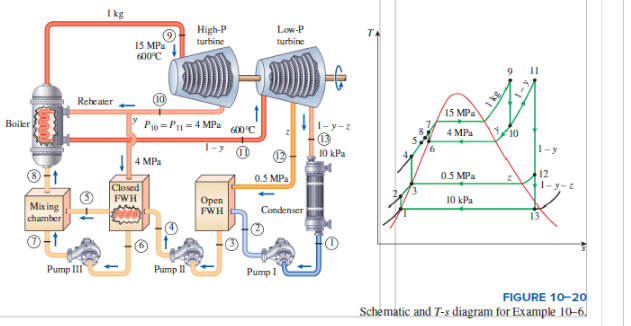

In [ ]:
## Dashboard / inputs
numPts  = 13;
numComp = 10;
pts = 1:numPts;

pre_pump    = [1,3,6]  # nodes before pump
post_pump   = [2,4,7]
pre_turb    = [9,11]
pre_siso_turb  = [9]
post_siso_turb = [10]
pre_simo_turb   = [11]
post_simo_turb  = [12,13]

T_pre_turb      = [585,585] # deg c
Pmax            = 33;


# open and closed feedwater heaters
cfwh_out_known = 6
cfwh_out_unkown = 5
cfwh_in = [10,4]
cfwh_out = [6,5]
ofwh_in = [12,2]
ofwh_out = [3]
mix_in = [5,7]
mix_out = [8]

post_mix = 8
pre_mix = [7,5]

#Isobars    #Assigning pressrues
isoP = Array{Any,1}(undef,4)
p = Vector{Float64}(undef,4)

p[1] = convert_pressure(4,:Mpa);    isoP[1] = [10,11,6];
p[2] = convert_pressure(15,:MPa);   isoP[2] = [4,5,8,7,9];
p[3] = convert_pressure(.5,:MPa);   isoP[3] = [2,3,12];    
p[4] = convert_pressure(10,:kPa);   isoP[4] = [13,1];   

press = zeros(numPts)   # vector of all pressures, units of Bar
count = 1;
for iso in isoP
    press[iso[:]] .= p[count]
    count+=1
end
@show press


steam_vec = Array{steamObj,1}(undef,numPts)
steam_vec[pre_pump] = h2o_initPrePump(press[pre_pump])
steam_vec[post_pump],pumpwork = h2o_pump(press[post_pump],steam_vec[pre_pump],1.0)
steam_vec[pre_turb] = h2o_initPreTurb(press[pre_turb],T_pre_turb)
steam_vec[post_siso_turb],turbwork = h2o_turbine(press[post_siso_turb],steam_vec[pre_siso_turb],1.0)
steam_vec[post_simo_turb],turbwork2 = h2o_simo_turbine(press[post_simo_turb],steam_vec[pre_simo_turb],1.0)
steam_vec[cfwh_out_unkown] = h2o_closed_feedwater_heater(steam_vec[cfwh_out_known],press[cfwh_out_unkown])
y = h2o_massFraction("cfw",steam_vec[cfwh_in],steam_vec[cfwh_out])
z = (1-y) * h2o_massFraction("ofw",steam_vec[ofwh_in],steam_vec[ofwh_out])
steam_vec[post_mix] = h2o_MixingChamber(y,steam_vec[pre_mix])
# @show steam_vec
steamt = steamTable(steam_vec)

wout = steam_vec[9].h-steam_vec[10].h+(1-y)*(steam_vec[11].h-steam_vec[12].h)+(1-y-z)*(steam_vec[12].h-steam_vec[13].h)
win = (1-y-z)*(steam_vec[2].h-steam_vec[1].h) + (1-y) * (steam_vec[4].h-steam_vec[3].h)+y*(steam_vec[7].h-steam_vec[6].h)
wnet = wout-win

qin = steam_vec[9].h-steam_vec[8].h+(1-y)*(steam_vec[11].h-steam_vec[10].h)
@show wnet/qin

steamt


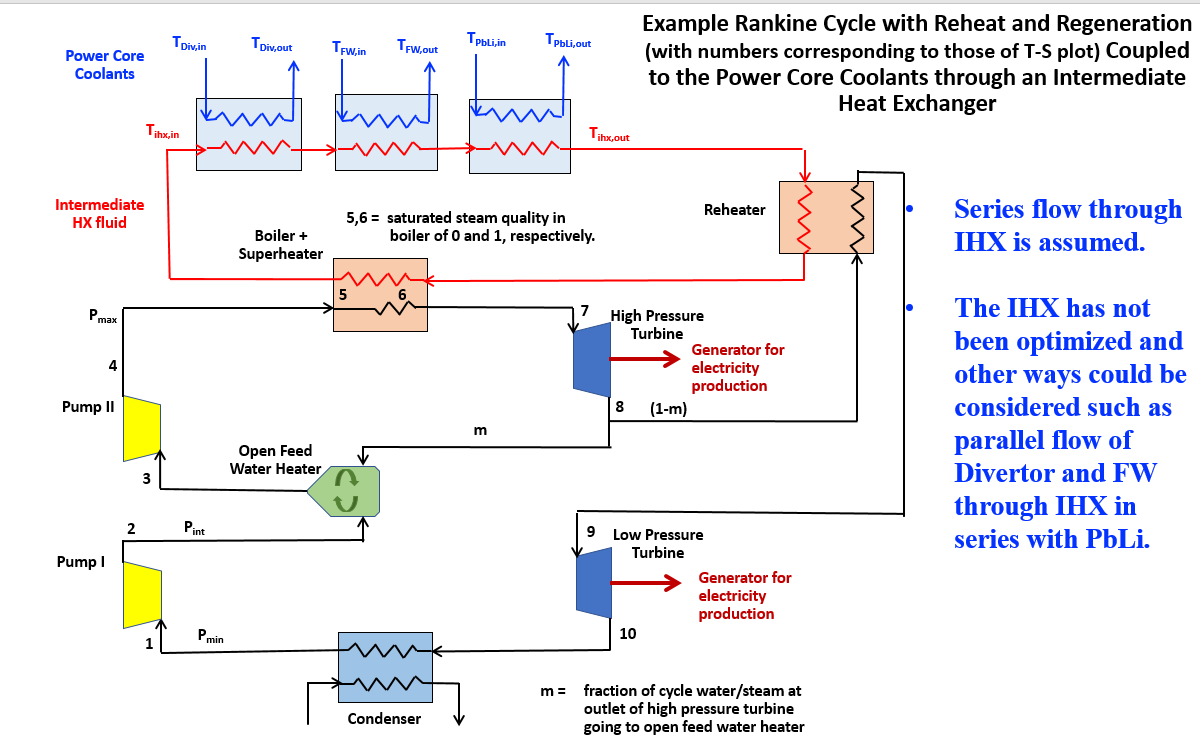

In [31]:
## Dashboard / inputs
# include("rankine_functions.jl")
function convert_pressure(val::Real,from_unit::Symbol,to_unit::Symbol)
    # default = SI
    # converting to lowercase to avoid errors
    from_unit = Symbol(lowercase(string(from_unit)))
    to_unit = Symbol(lowercase(string(to_unit)))

    # unit vector (pun)
    units = (pa = 1.0, kpa = 1.0e3, mpa = 1.0e6, gpa = 1.0e9, psi = 6.8947572932e3, ksi = 6.8947572932e3 * 1000 ,bar = 100000.0, atm = 101325.0, inh2o = 249.082);

    inUnit = units[from_unit]
    outUnit = units[to_unit]
    return val/(outUnit/inUnit)
end
function convert_pressure(val::Real,from_unit::Symbol)
    # default = SI
    # converting to lowercase to avoid errors
    from_unit = Symbol(lowercase(string(from_unit)))
    to_unit = :bar

    # unit vector (pun)
    units = (pa = 1.0, kpa = 1.0e3, mpa = 1.0e6, gpa = 1.0e9, psi = 6.8947572932e3, ksi = 6.8947572932e3 * 1000 ,bar = 100000.0, atm = 101325.0, inh2o = 249.082);

    inUnit = units[from_unit]
    outUnit = units[to_unit]
    return val/(outUnit/inUnit)
end
using XSteam

numPts = 10;
numComp = 8;
pts = 1:numPts;

pre_pump        = [1,3]  # nodes before pump
post_pump       = [2,4]
pre_turb        = [7,9]
pre_siso_turb   = [7,9]
post_siso_turb  = [8,10]
T_pre_turb      = [329,585] # deg c
Pmax = 34
Pmin = 0.15

# @show P8 = (T_pre_turb[1])
P8 = 9.7;

# open and closed feedwater heaters
ofwh_in = [8,2]
ofwh_out = [3]

#Isobars    #Assigning pressrues
isoP = Array{Any,1}(undef,3)
p   = Vector{Float64}(undef,3)

p[1] = (Pmax);    isoP[1] = [4,5,6,7];
p[2] = (P8);      isoP[2] = [2,3,8,9];    
p[3] = (Pmin);    isoP[3] = [1,10];   

press = zeros(numPts)   # vector of all pressures, units of Bar
count = 1;
for iso in isoP
    press[iso[:]] .= p[count]
    count+=1
end



steam_vec                       = Array{steamObj,1}(undef,numPts)
steam_vec[pre_pump]             = h2o_initPrePump(press[pre_pump])
# steam_vec[5] = steam_vec[4]
steam_vec[post_pump],pumpwork       = h2o_pump(press[post_pump],steam_vec[pre_pump],0.8)
steam_vec[pre_turb]                 = h2o_initPreTurb(press[pre_turb],T_pre_turb)
steam_vec[post_siso_turb],turbwork = h2o_turbine(press[post_siso_turb], steam_vec[pre_siso_turb],   .9)

# @show y =  h2o_massFraction("ofw",steam_vec[ofwh_in],steam_vec[ofwh_out])
# steam_vec[6] =  steam_vec[7]
steamt = steamTable(steam_vec)

# wout = steamt[6,2]
# 

,P_bar,T_degC,h_kJ_kg,s_kJ_kg,x
,Float64,Float64,Float64,Float64,Float64
1,0.15,53.9703,225.935,0.754936,0.0
2,9.7,54.0726,227.166,0.755724,0.0
3,9.7,178.566,756.859,2.12583,0.0
4,34.0,179.104,760.383,2.12757,0.0
5,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0,-1.0,-1.0
7,34.0,329.0,3055.8,6.59244,1.0
8,9.7,188.878,2802.7,6.65404,1.0
9,9.7,585.0,3665.5,8.00675,1.0


In [49]:
@show y =  h2o_massFraction("ofw",steam_vec[ofwh_in],steam_vec[ofwh_out])
hcol = 3

@show wout  =   steamt[7,hcol] - steamt[8,hcol] + (1-y) * (steamt[9,hcol]-steamt[10,hcol])
@show qin   =   steamt[7,hcol] -  steamt[4,hcol] +    (1-y) * (steamt[9,hcol] - steamt[8,hcol])
@show wnet  =   wout- sum(pumpwork)


wnet/qin

y = h2o_massFraction("ofw", steam_vec[ofwh_in], steam_vec[ofwh_out]) = 0.2056631357533352
wout = (steamt[7, hcol] - steamt[8, hcol]) + (1 - y) * (steamt[9, hcol] - steamt[10, hcol]) = 1016.1232622362464
qin = (steamt[7, hcol] - steamt[4, hcol]) + (1 - y) * (steamt[9, hcol] - steamt[8, hcol]) = 2980.766060345602
wnet = wout - sum(pumpwork) = 1011.3679002415495


0.33929797903170145

In [47]:
# sum(pumpwork)
sum(turbwork)

steamt[7,hcol]

1213.6805943146346

In [ ]:

# steam_vec[post_simo_turb],turbwork2 = h2o_simo_turbine(press[post_simo_turb],steam_vec[pre_simo_turb],.9)

# steam_vec[cfwh_out_unkown] = h2o_closed_feedwater_heater(steam_vec[cfwh_out_known],press[cfwh_out_unkown])
# y = h2o_massFraction("cfw",steam_vec[cfwh_in],steam_vec[cfwh_out])

y = h2o_massFraction("ofw",steam_vec[ofwh_in],steam_vec[ofwh_out])

# steam_vec[post_mix] = h2o_MixingChamber(y,steam_vec[pre_mix])
# @show steam_vec
steamt = steamTable(steam_vec)

# wout = steam_vec[9].h-steam_vec[10].h+(1-y)*(steam_vec[11].h-steam_vec[12].h)+(1-y-z)*(steam_vec[12].h-steam_vec[13].h)
# win = (1-y-z)*(steam_vec[2].h-steam_vec[1].h) + (1-y) * (steam_vec[4].h-steam_vec[3].h)+y*(steam_vec[7].h-steam_vec[6].h)
# wnet = wout-win

# qin = steam_vec[9].h-steam_vec[8].h+(1-y)*(steam_vec[11].h-steam_vec[10].h)
wnet/qin
steamt

In [ ]:

using Gtk
using Plots

function create_window()
    # create the window
    win = GtkWindow("Plots.jl Example", 400, 300)
    vbox = GtkBox(:v)
    push!(win, vbox)

    # create the plot
    x = range(0, 2π, length=50)
    y = sin.(x)
    p = plot(x, y)

    # add the plot to the window
    canvas = GtkCanvas(p, win)
    push!(vbox, canvas)

    # show the window
    showall(win)
end

create_window()
